In [30]:
!pip3 install transforms3d
!pip3 install jax
!pip3 install jaxlib
!pip3 install autograd

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [6]:
import os
import time
# import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import importlib
import torch

import transforms3d

import jax.numpy as np
from jax import grad, jacrev
from jax import random

# import autograd.numpy as np
# from autograd import grad

import load_data
from rotplot import rotplot
# from utils import *

In [14]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [7]:
GRAVITY = -1.0

In [9]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# kwargs = {'num_workers': args.num_workers, 'pin_memory': False} if device.type == "cuda" else {}

# Additional Info when using cuda
if device.type == 'cuda':
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 3), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 3), 'GB')

Number of GPU devices: 1
GPU device name: TITAN RTX
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Load Dataset

In [10]:
# load data
dataset_index = "1"

start_time = time.time()
if dataset_index in ["1", "2", "8", "9"]:
    cfile = "../data/trainset/cam/cam" + dataset_index + ".p"
    camd = load_data.read_data(cfile)
else:
    camd = None

ifile = "../data/trainset/imu/imuRaw" + dataset_index + ".p"
imud = load_data.read_data(ifile)

vfile = "../data/trainset/vicon/viconRot" + dataset_index + ".p"
vicd = load_data.read_data(vfile)
print('%s took: %s sec.\n' % ("Data import", round(time.time() - start_time, 4)))

print("Raw Data:")
print("Camera data:", camd.keys(), camd['cam'].shape, camd['ts'].shape)
print("IMU data:", imud.keys(), imud['vals'].shape, imud['ts'].shape)
print("VICON data:", vicd.keys(), vicd['rots'].shape, vicd['ts'].shape)

Data import took: 4.2115 sec.

Raw Data:
Camera data: dict_keys(['cam', 'ts']) (240, 320, 3, 1685) (1, 1685)
IMU data: dict_keys(['vals', 'ts']) (6, 5645) (1, 5645)
VICON data: dict_keys(['rots', 'ts']) (3, 3, 5561) (1, 5561)


In [4]:
# key = random.PRNGKey(seed=1701)
# a = random.randint(key, (3,6), 0, 9)
# print(a)

# a = a.at[:, [5,3,4]].set(a[:, [3,4,5]])
# print(a)

In [13]:
cam_arr, cam_ts_unix = np.transpose(camd['cam'], (3, 0, 1, 2)), camd['ts'].T
imu_arr, imu_ts_unix = np.array(imud['vals'].T, dtype=np.float32), imud['ts'].T
imu_arr = imu_arr.at[:, [5, 3, 4]].set(imu_arr[:, [3, 4, 5]])
vic_arr, vic_ts_unix = np.transpose(vicd['rots'], (2, 0, 1)), vicd['ts'].T

cam_ts = cam_ts_unix - cam_ts_unix[0]
imu_ts = imu_ts_unix - imu_ts_unix[0]
vic_ts = vic_ts_unix - vic_ts_unix[0]

print("Camera data:", cam_arr.shape, cam_ts.shape)
print("IMU data:", imu_arr.shape, imu_ts.shape)   # (Ax, Ay, Az, Wx, Wy, Wz)
print("VICON data:", vic_arr.shape, vic_ts.shape)

Camera data: (1685, 240, 320, 3) (1685, 1)
IMU data: (5645, 6) (5645, 1)
VICON data: (5561, 3, 3) (5561, 1)


## Plot IMU Acclm and Gyroscope data (raw / biased)

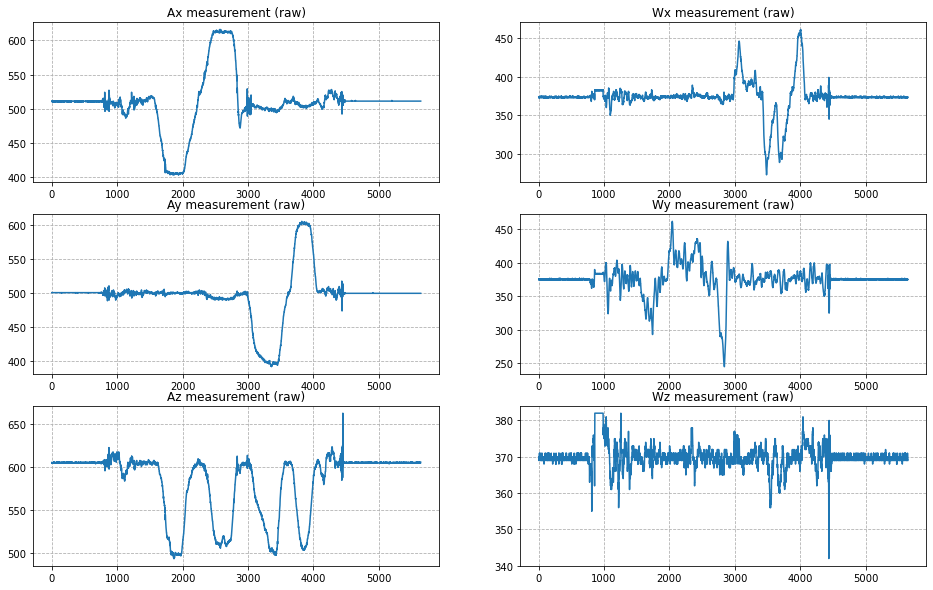

In [25]:
# plot IMU accelerometer data (biased)
num_samp_plot = imu_arr.shape[0]
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(imu_arr[0:num_samp_plot, 0])
plt.grid(linestyle='--')
plt.title("Ax measurement (raw)")

plt.subplot(3, 2, 3)
plt.plot(imu_arr[0:num_samp_plot, 1])
plt.grid(linestyle='--')
plt.title("Ay measurement (raw)")

plt.subplot(3, 2, 5)
plt.plot(imu_arr[0:num_samp_plot, 2])
plt.grid(linestyle='--')
plt.title("Az measurement (raw)")

# plot IMU gyroscope data (biased)
num_samp_plot = imu_arr.shape[0]
plt.subplot(3, 2, 2)
plt.plot(imu_arr[0:num_samp_plot, 3])
plt.grid(linestyle='--')
plt.title("Wx measurement (raw)")

plt.subplot(3, 2, 4)
plt.plot(imu_arr[0:num_samp_plot, 4])
plt.grid(linestyle='--')
plt.title("Wy measurement (raw)")

plt.subplot(3, 2, 6)
plt.plot(imu_arr[0:num_samp_plot, 5])
plt.grid(linestyle='--')
plt.title("Wz measurement (raw)")

plt.show()

## Estimate Acclm and gyroscope bias

In [28]:
# estimate accelerometer bias
num_init_samp_bias = 500
imu_acclm_bias = np.mean(imu_arr[0:num_init_samp_bias, 0:3], axis=0)
print("Accelerometer bias:", imu_acclm_bias)

# estimate gyrometer bias
num_init_samp_bias = 500
imu_gyro_bias = np.mean(imu_arr[0:num_init_samp_bias, 3:6], axis=0)
print("Gyroscope bias:", imu_gyro_bias)

imu_arr_unbiased = np.copy(imu_arr)
imu_arr_unbiased = imu_arr_unbiased.at[:, 0:3].set(imu_arr_unbiased[:, 0:3] - imu_acclm_bias)
imu_arr_unbiased = imu_arr_unbiased.at[:, 3:6].set(imu_arr_unbiased[:, 3:6] - imu_gyro_bias)

print("Acclerometer data (unbiased):\n", imu_arr_unbiased[:, 0:3])
print("Gyroscope data (unbiased):\n", imu_arr_unbiased[:, 3:6])

Accelerometer bias: [510.808   500.99402 605.164  ]
Gyroscope bias: [373.56802 375.35602 369.68002]
Acclerometer data (unbiased):
 [[ 0.19198608  0.00598145 -0.16400146]
 [ 0.19198608  0.00598145 -0.16400146]
 [ 0.19198608  0.00598145  0.83599854]
 ...
 [ 0.19198608 -0.99401855 -0.16400146]
 [ 0.19198608 -0.99401855 -0.16400146]
 [ 0.19198608 -0.99401855  0.83599854]]
Gyroscope data (unbiased):
 [[ 0.43197632  0.64398193  0.3199768 ]
 [-0.5680237   0.64398193 -0.6800232 ]
 [ 0.43197632 -0.35601807  0.3199768 ]
 ...
 [-0.5680237  -0.35601807 -0.6800232 ]
 [ 0.43197632  0.64398193 -0.6800232 ]
 [-0.5680237  -0.35601807 -0.6800232 ]]


## Plot IMU Acclm and Gyroscope data (Unbiased)

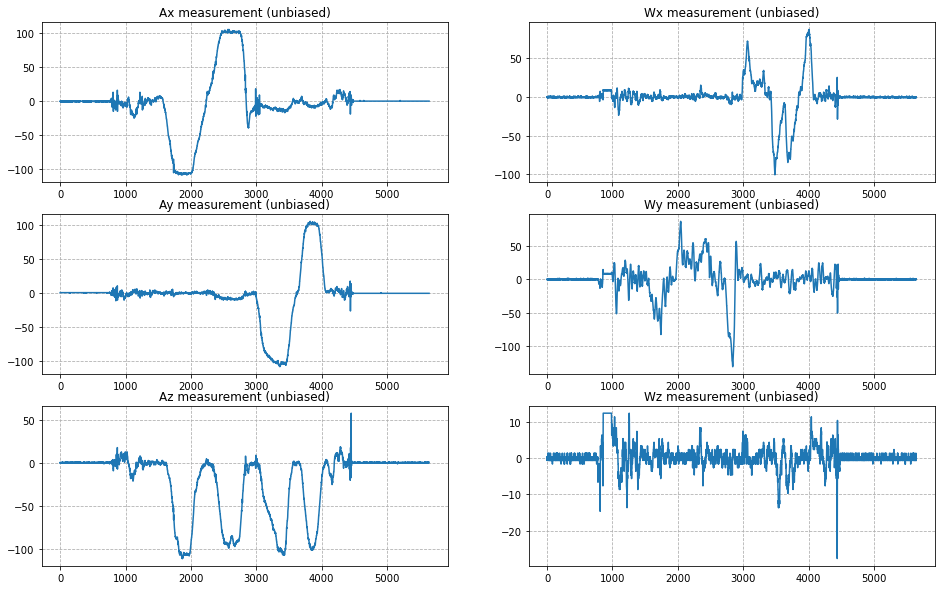

In [29]:
# plot IMU accelerometer data (Unbiased)
num_samp_plot = imu_arr.shape[0]
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 0])
plt.grid(linestyle='--')
plt.title("Ax measurement (unbiased)")

plt.subplot(3, 2, 3)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 1])
plt.grid(linestyle='--')
plt.title("Ay measurement (unbiased)")

plt.subplot(3, 2, 5)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 2])
plt.grid(linestyle='--')
plt.title("Az measurement (unbiased)")

# plot IMU gyroscope data (unbiased)
num_samp_plot = imu_arr.shape[0]
plt.subplot(3, 2, 2)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 3])
plt.grid(linestyle='--')
plt.title("Wx measurement (unbiased)")

plt.subplot(3, 2, 4)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 4])
plt.grid(linestyle='--')
plt.title("Wy measurement (unbiased)")

plt.subplot(3, 2, 6)
plt.plot(imu_arr_unbiased[0:num_samp_plot, 5])
plt.grid(linestyle='--')
plt.title("Wz measurement (unbiased)")

plt.show()

## IMU calibration - Compute sensitivity & scale factor

In [31]:
Vref = 3300.0
sens_gyro = 3.33 / (np.pi/180)
sens_acclm = 300 / GRAVITY
print("Sensitivity: Acclm =", sens_acclm, "mV/m/sec2,  Gyro =", sens_gyro, "mV/rad/sec")

scale_gyro = Vref / (1023 * sens_gyro)
scale_acclm = Vref / (1023 * sens_acclm)
print("Scale: Acclm = ", scale_acclm, "m/sec2,  Gyro =", scale_gyro, "rad-sec")

imu_arr_cal = np.copy(imu_arr_unbiased)
imu_arr_cal = imu_arr_cal.at[:, 0:3].set(imu_arr_cal[:, 0:3] * scale_acclm)
imu_arr_cal = imu_arr_cal.at[:, 0:2].set(imu_arr_cal[:, 0:2] * -1.0)
imu_arr_cal = imu_arr_cal.at[:, 3:6].set(imu_arr_cal[:, 3:6] * scale_gyro)

Sensitivity: Acclm = -30.612244897959183 mV/m/sec2,  Gyro = 190.79494577856414 mV/rad/sec
Scale: Acclm =  -0.1053763440860215 m/sec2,  Gyro = 0.01690719027409018 rad-sec


## Plot IMU Acclm and Gyroscope data (full calibrated)

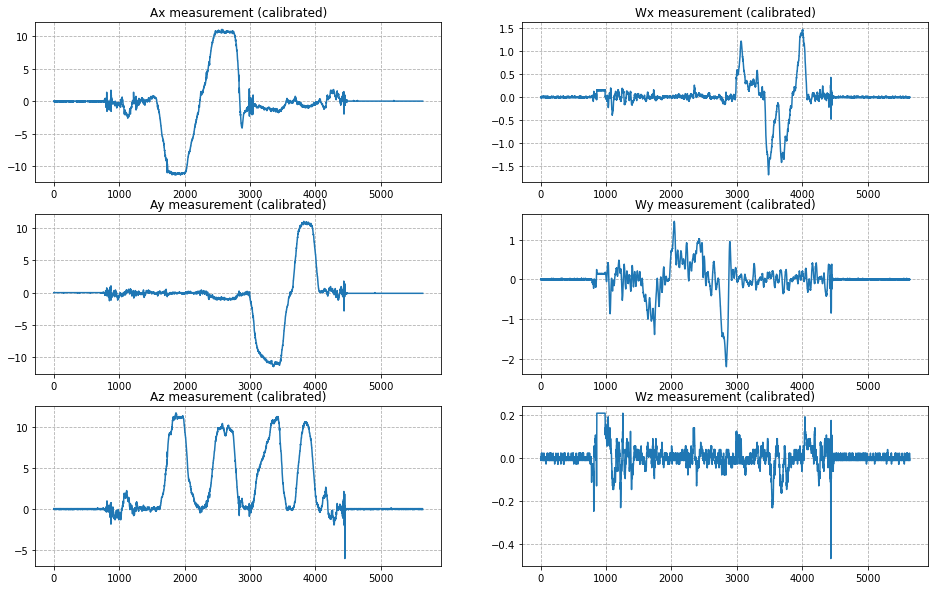

In [32]:
# plot IMU accelerometer data (calibrated)
num_samp_plot = imu_arr.shape[0]
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(imu_arr_cal[0:num_samp_plot, 0])
plt.grid(linestyle='--')
plt.title("Ax measurement (calibrated)")

plt.subplot(3, 2, 3)
plt.plot(imu_arr_cal[0:num_samp_plot, 1])
plt.grid(linestyle='--')
plt.title("Ay measurement (calibrated)")

plt.subplot(3, 2, 5)
plt.plot(imu_arr_cal[0:num_samp_plot, 2])
plt.grid(linestyle='--')
plt.title("Az measurement (calibrated)")

# plot IMU gyroscope data (calibrated)
num_samp_plot = imu_arr.shape[0]
plt.subplot(3, 2, 2)
plt.plot(imu_arr_cal[0:num_samp_plot, 3])
plt.grid(linestyle='--')
plt.title("Wx measurement (calibrated)")

plt.subplot(3, 2, 4)
plt.plot(imu_arr_cal[0:num_samp_plot, 4])
plt.grid(linestyle='--')
plt.title("Wy measurement (calibrated)")

plt.subplot(3, 2, 6)
plt.plot(imu_arr_cal[0:num_samp_plot, 5])
plt.grid(linestyle='--')
plt.title("Wz measurement (calibrated)")

plt.show()

In [33]:
def compute_exp_quat(q):
    qs = q[0]
    qv = q[1:]
    qv_mag = np.linalg.norm(qv)
    
    exp_q = np.zeros_like(q)
    exp_q[0] = np.exp(qs) * np.cos(qv_mag)
    exp_q[1:] = np.exp(qs) * np.sin(qv_mag) * qv / qv_mag
    
    return exp_q

def compute_log_quat(q):
    qv_mag = np.linalg.norm(q[1:])
    q_mag = np.linalg.norm(q)
    tmp = np.arccos(q[0] / q_mag) / qv_mag
    
#     log_q = np.zeros((4))
#     log_q[0] = np.log(q_mag)
#     log_q[1:] = (qv / qv_mag) * np.arccos(qs / q_mag)
    
    log_q = np.array([np.log(q_mag), q[1]*tmp, q[2]*tmp, q[3]*tmp])
    
    return log_q

def compute_quat_inv(q):
#     q_inv = np.zeros_like(q)
    
    q_inv = np.array([q[0], -q[1], -q[2], -q[3]])
    q_inv = q_inv / np.linalg.norm(q)**2
#     q_inv[1:] *= -1
    
    return q_inv

def compute_quat_prod(q, p):
    assert(q.shape[0] == p.shape[0] == 4)
#     quat_prod = np.zeros_like(q)
#     quat_prod = np.zeros((4), dtype=np.float32)

#     print("Stage-1:", q[0] * p[0] - np.sum(q[1:] * p[1:]))
#     quat_prod[0] = q[0] * p[0] - np.dot(q[1:], p[1:])
#     quat_prod[0] = q[0] * p[0] - q[1] * p[1] - q[2] * p[2] - q[3] * p[3]
#     quat_prod[1:] = q[0] * p[1:] + p[0] * q[1:] + np.cross(q[1:], p[1:])
    tmp = np.array([q[0] * p[1:] + p[0] * q[1:] + np.cross(q[1:], p[1:])])
#     print(tmp)
    
    quat_prod = np.array([q[0] * p[0] - np.dot(q[1:], p[1:]), tmp[0,0], tmp[0,1], tmp[0,2]])
    
    return quat_prod

def compute_f(q, tau, omega):
    quat_omega = np.insert(tau * omega / 2, 0, 0)
    exp_quat_omega = compute_exp_quat(quat_omega)
    f_out = compute_quat_prod(q, exp_quat_omega)
    
    return f_out

def compute_h(q):
    tmp = np.array([0, 0, 0, -GRAVITY], dtype=np.float32)
    return compute_quat_prod(compute_quat_prod(compute_quat_inv(q), tmp), q)

## Estimate True vs Estimated Roll, Pitch, Yaw

In [38]:
# estimate true euler angles from VICON data
num_vic_ts = vic_ts.shape[0]
vic_rpy_arr = np.zeros((num_vic_ts, 3), dtype=np.float32)

start_time = time.time()
for t in range(num_vic_ts):
    rot_mat = vic_arr[t]
    vic_rpy_arr = vic_rpy_arr.at[t, :].set(np.array(transforms3d.euler.mat2euler(rot_mat)) * 180 / np.pi)
print("Time taken:", round(time.time() - start_time, 4))

# estimate predicted euler angles from IMU data using quaternion kinematics motion model
num_imu_ts = imu_ts.shape[0]
imu_pred_rpy_arr = np.zeros((num_imu_ts, 3), dtype=np.float32)

quat_pred = np.zeros((num_imu_ts, 4), dtype=np.float32)
quat_pred = quat_pred.at[0].set(np.array([1, 0, 0, 0], dtype=np.float32))   # define q0
imu_pred_rpy_arr[0] = np.array(transforms3d.euler.quat2euler(quat_pred[0], axes='sxyz')) * 180 / np.pi

accln_pred = np.zeros((num_imu_ts, 3), dtype=np.float32)
accln_pred[0] = compute_h(quat_pred[0])[1:]

for t in range(num_imu_ts - 1):
    tau_t = imu_ts[t+1] - imu_ts[t]
    omega_t = imu_arr_cal[t, 3:6]
    quat_pred[t+1] = compute_f(quat_pred[t], tau_t, omega_t)
    
    imu_pred_rpy_arr[t+1, :] = np.array(transforms3d.euler.quat2euler(quat_pred[t+1], axes='sxyz')) * 180 / np.pi
    
    # compute acceleration using observation model
    accln_pred[t+1] = compute_h(quat_pred[t+1])[1:]

Time taken: 13.5899


TypeError: '<class 'jaxlib.xla_extension.Array'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

## Plot True vs Estimated Roll, Pitch, Yaw

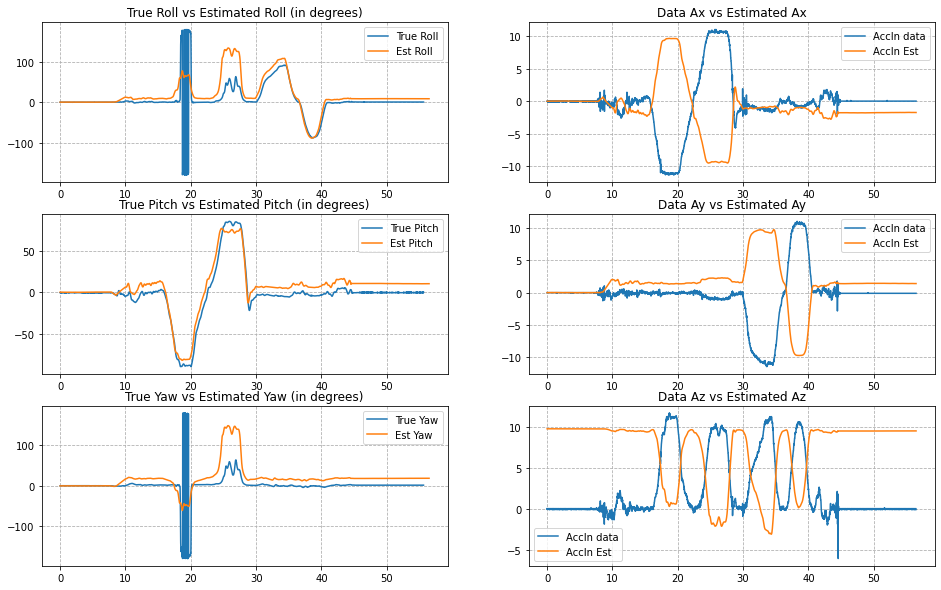

In [56]:
fig = plt.figure(figsize=(16,10))
plt.subplot(3, 2, 1)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,0], label="True Roll")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,0], label="Est Roll")
plt.grid(linestyle='--')
plt.title("True Roll vs Estimated Roll (in degrees)")
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,1], label="True Pitch")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,1], label="Est Pitch")
plt.grid(linestyle='--')
plt.title("True Pitch vs Estimated Pitch (in degrees)")
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(vic_ts[0:num_vic_ts], vic_rpy_arr[:,2], label="True Yaw")
plt.plot(imu_ts[0:num_imu_ts], imu_pred_rpy_arr[:,2], label="Est Yaw")
plt.grid(linestyle='--')
plt.title("True Yaw vs Estimated Yaw (in degrees)")
plt.legend()


plt.subplot(3, 2, 2)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,0], label="Accln data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred[:,0], label="Accln Est")
plt.grid(linestyle='--')
plt.title("Data Ax vs Estimated Ax")
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,1], label="Accln data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred[:,1], label="Accln Est")
plt.grid(linestyle='--')
plt.title("Data Ay vs Estimated Ay")
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(imu_ts[0:num_imu_ts], imu_arr_cal[:,2], label="Accln data")
plt.plot(imu_ts[0:num_imu_ts], accln_pred[:,2], label="Accln Est")
plt.grid(linestyle='--')
plt.title("Data Az vs Estimated Az")
plt.legend()

plt.show()

/home/sazim/private/ECE276A/code/rotplot.py:28: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


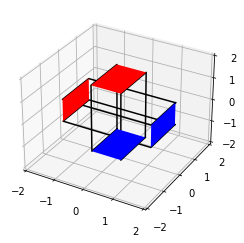

In [142]:
REye = np.eye(3)
myAxis = rotplot(REye)
RTurn = np.array([[np.cos(np.pi/2),0,np.sin(np.pi/2)],[0,1,0],[-np.sin(np.pi/2),0,np.cos(np.pi/2)]])
rotplot(RTurn,myAxis)
plt.show()

In [110]:
# body_arr_cal = np.copy(imu_arr_cal)
# body_arr_cal[:, 0:2] = -1 * body_arr_cal[:, 0:2]

In [61]:
def compute_cost_func(quat_arr):
    cost = 0
    
    num_imu_ts = quat_arr.shape[0]
    
    for t in range(0, num_imu_ts-1):
        tau_t = imu_ts[t+1] - imu_ts[t]
        omega_t = imu_arr_cal[t, 3:6]
        f_out = compute_f(quat_arr[t], tau_t, omega_t)
        h_out = compute_h(quat_arr[t])[1:]
        
        cost += np.linalg.norm(2 * compute_log_quat(compute_quat_prod(compute_quat_inv(quat_arr[t+1]), f_out)))**2
        
        accln_t = imu_arr_cal[t, 0:3]
        cost += np.linalg.norm(accln_t - h_out)**2
    
    cost *= 0.5
    return cost

## Perform PGD steps

Iteration: 0
Iteration: 1


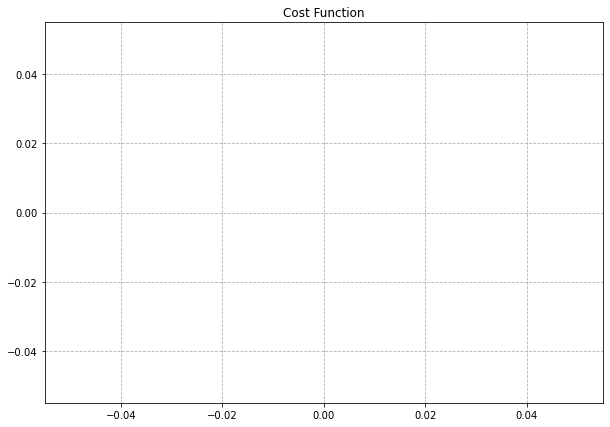

In [62]:
q0 = np.array([1, 0, 0, 0], dtype=np.float32)

# estimate predicted euler angles from IMU data using quaternion kinematics motion model
num_imu_ts = imu_ts.shape[0]
# imu_pred_rpy_arr = np.zeros((num_imu_ts-1, 3), dtype=np.float32)

quat_arr = np.zeros((num_imu_ts, 4), dtype=np.float32)
quat_arr[0] = np.array([1, 0, 0, 0], dtype=np.float32)   # define q0

for t in range(0, num_imu_ts - 1):
    tau_t = imu_ts[t+1] - imu_ts[t]
    omega_t = imu_arr_cal[t, 3:6]
    quat_arr[t+1] = compute_f(quat_pred[t], tau_t, omega_t)

cost_lst = []
grad_cost_fn = grad(compute_cost_func)

num_itr = 2
learning_rate = 1e-2
for itr in range(num_itr):
#     for t in range(num_imu_ts):
#         print(quat_arr[t])
    quat_arr = quat_arr - learning_rate * grad_cost_fn(quat_arr)
    print("Iteration:", itr)
    cost_lst.append(compute_cost_func(quat_arr))

fig = plt.figure(figsize=(10, 7))
plt.plot(cost_lst)
plt.grid(linestyle='--')
plt.title("Cost Function")
plt.show()

In [63]:
cost_lst

[nan, nan]